# Tutorial: Mouse cortex single-cell callingcards data. 

 This is a brd4 single-cell(sc) callingcards dataset in mouse cortex from [Moudgil et al., Cell. (2020)](https://doi.org/10.1016/j.cell.2020.06.037) and could be downloaded from [GEO](https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSE148448).
 
 In this tutorial, we will call peaks, make annotation, do differential peak analysis, pair peaks with genes. In this dataset, there are 111382 insertions and 35950 cells in tatal. However, many cells are filted in scRNA-seq analysis.

In [1]:
import pycallingcards as cc
import numpy as np
import pandas as pd
import scanpy as sc

We start by reading qbed data. In this data, one row is one insertion and columns indecate the chromosome, start point and end point, read number, direction and cell borcode of each insertion. For example, the first row means one insertion is on Chromosome 1 and starts from 3112541 to 3112545. The read number is 12 with the direction from 3' to 5'. The barcode of the cell is GATGAAAAGAGTTGGC-1. Note that the barcodes of cells would be consistent with scRNA-seq data.

You could use ```cc.rd.read_qbed(filename)``` to read your own qbed data.

In [2]:
qbed_data = cc.datasets.mousecortex_data(data="qbed")
qbed_data 

,Chr,Start,End,Reads,Direction,Barcodes
0,chr1,3112541,3112545,12,+,GATGAAAAGAGTTGGC-1
1,chr1,3121337,3121341,6,-,CGATCGGCACATTTCT-1
2,chr1,3199281,3199285,7,+,GTCCTCATCTCCGGTT-1
3,chr1,3211433,3211437,22,-,CGAGAAGAGGAATCGC-1
4,chr1,3245859,3245863,149,+,TTTACTGCATCCGCGA-1
...,...,...,...,...,...,...
111377,chrY,90807968,90807972,200,-,ACGGAGAGTCGCATAT-1
111378,chrY,90833531,90833535,51,-,TAGCCGGTCCTGTACC-1
111379,chrY,90833600,90833604,13,-,TTGGCAAAGAATTGTG-1
111380,chrY,90840262,90840266,8,-,GTGCATAGTACCAGTT-1


Because insertions are discrete, we now call peaks to deduce potential binding sites. Three different methods (*CCcaller,cc_tools,Blockify*) are available along with there different species (*hg38,mm10,sacCer3*). 

In this setting, we use ***CCcaller*** in *mouse*('mm10') data. *maxbetween* is the most important parameter for *CCcaller*, it would control the maximum distance bwtween two nearby insertions, in another word, that is the minimun distance between two peaks. 800-2500 is a good parameter for *maxbetween*.  *pvalue_cutoff* is also an important parameter and a number below 0.05 is strongly advised.

In [3]:
peak_data = cc.pp.call_peaks(qbed_data, method = "CCcaller", reference = "mm10",  maxbetween = 2000, pvalue_cutoff = 0.01,
                  lam_win_size = 1000000,  pseudocounts = 1, record = True, save = 'mouse_cortex.bed')
peak_data

For the CCcaller method without background, [expdata, reference, pvalue_cutoff, lam_win_size, pseudocounts, minlen, extend, maxbetween, test_method, min_insertions, record] would be utilized.


100%|██████████| 21/21 [01:06<00:00,  3.14s/it]


,Chr,Start,End,Experiment Insertions,Reference Insertions,Expected Insertions,pvalue
0,chr1,3399868,3400272,5,4,1.031353,6.965061e-04
1,chr1,4806673,4809049,12,20,1.120541,2.498336e-10
2,chr1,9300144,9300901,5,5,1.037149,7.168254e-04
3,chr1,14302176,14310895,14,92,1.523252,1.015569e-10
4,chr1,15287495,15288141,8,4,1.029800,1.427167e-06
...,...,...,...,...,...,...,...
2166,chrX,166172262,166174518,6,10,1.137755,1.824630e-04
2167,chrX,166241178,166243587,8,18,1.257844,7.050309e-06
2168,chrX,166345453,166350005,11,35,1.507674,7.204418e-08
2169,chrX,168117814,168120255,7,21,1.162110,2.957329e-05



In order to choose suitable method and parameters for peak calling, please take a look at genome areas. We stongly advise to adjust the parameters for ```cc.pp.callpeaks()``` to call better peaks.

In this plot, the first part is insertions and their read counts. One dot is an insertion and the height is log(reads+1). The second part is the distribution of insertions. The third part represents reference genes and peaks. 

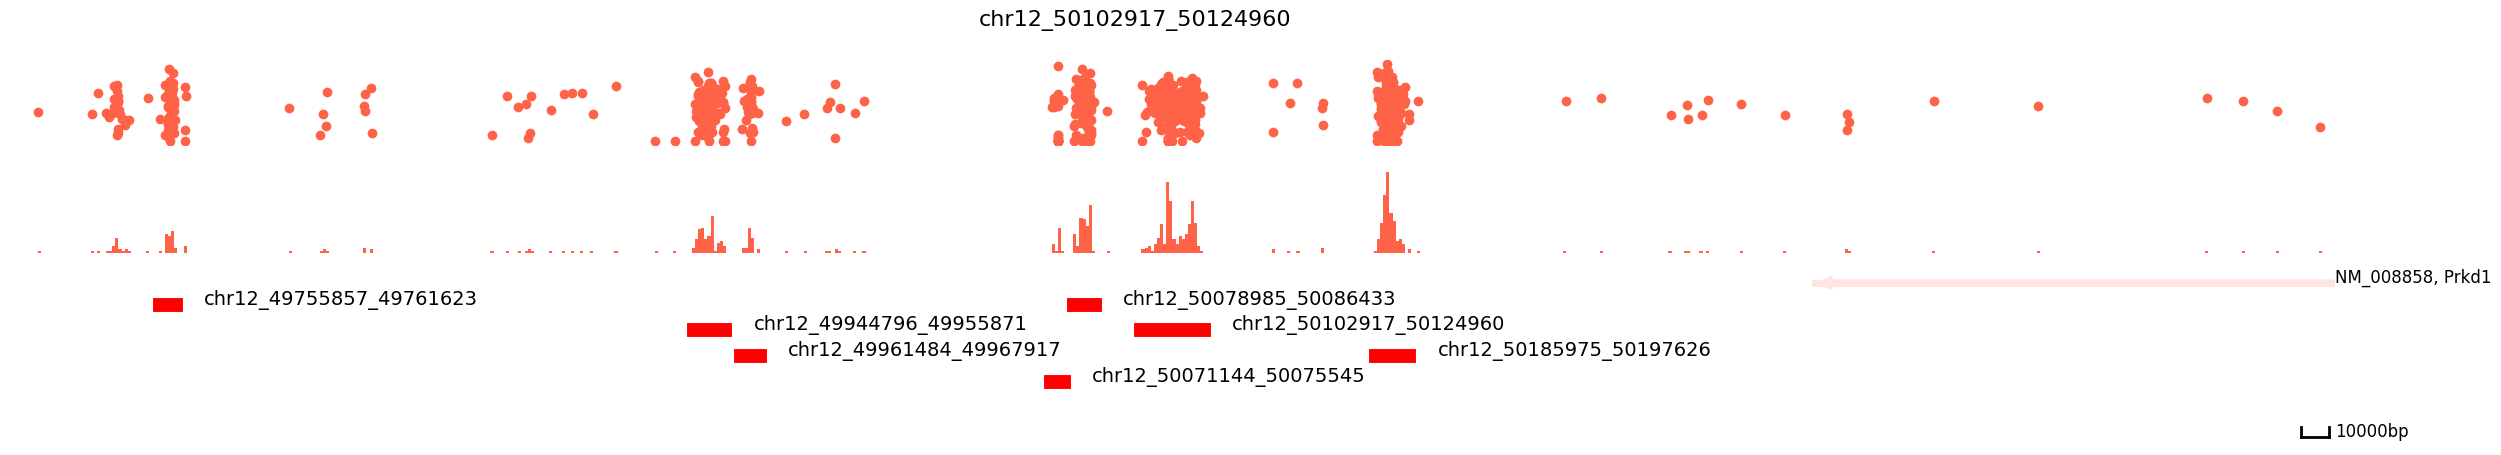

In [4]:
cc.pl.draw_area("chr12",50102917,50124960,400000,peak_data,qbed_data,"mm10",
                figsize = (30,5),peak_line = 4,save = True, title = "chr12_50102917_50124960")

We could also visualize our data in [WashU Epigenome Browser](http://epigenomegateway.wustl.edu/browser/) directly. 
Notice that this link only valid for 24h, please rerun it if you want to use it.

In [5]:
qbed = {"qbed_data": qbed_data}
bed = {"peak":peak_data}
cc.pl.WashU_browser_url(qbed = qbed,bed = bed,genome = 'mm10')

All qbed addressed
All bed addressed
Uploading files
Please click the following link to see the data on WashU Epigenome Browser directly.
https://epigenomegateway.wustl.edu/browser/?genome=mm10&hub=https://companion.epigenomegateway.org//task/96a50d1ec72872c3c7e8973c5237e89e/output//datahub.json


We advise to look at the whole chromosome and see the distribution of peaks to make sure everything is going right.

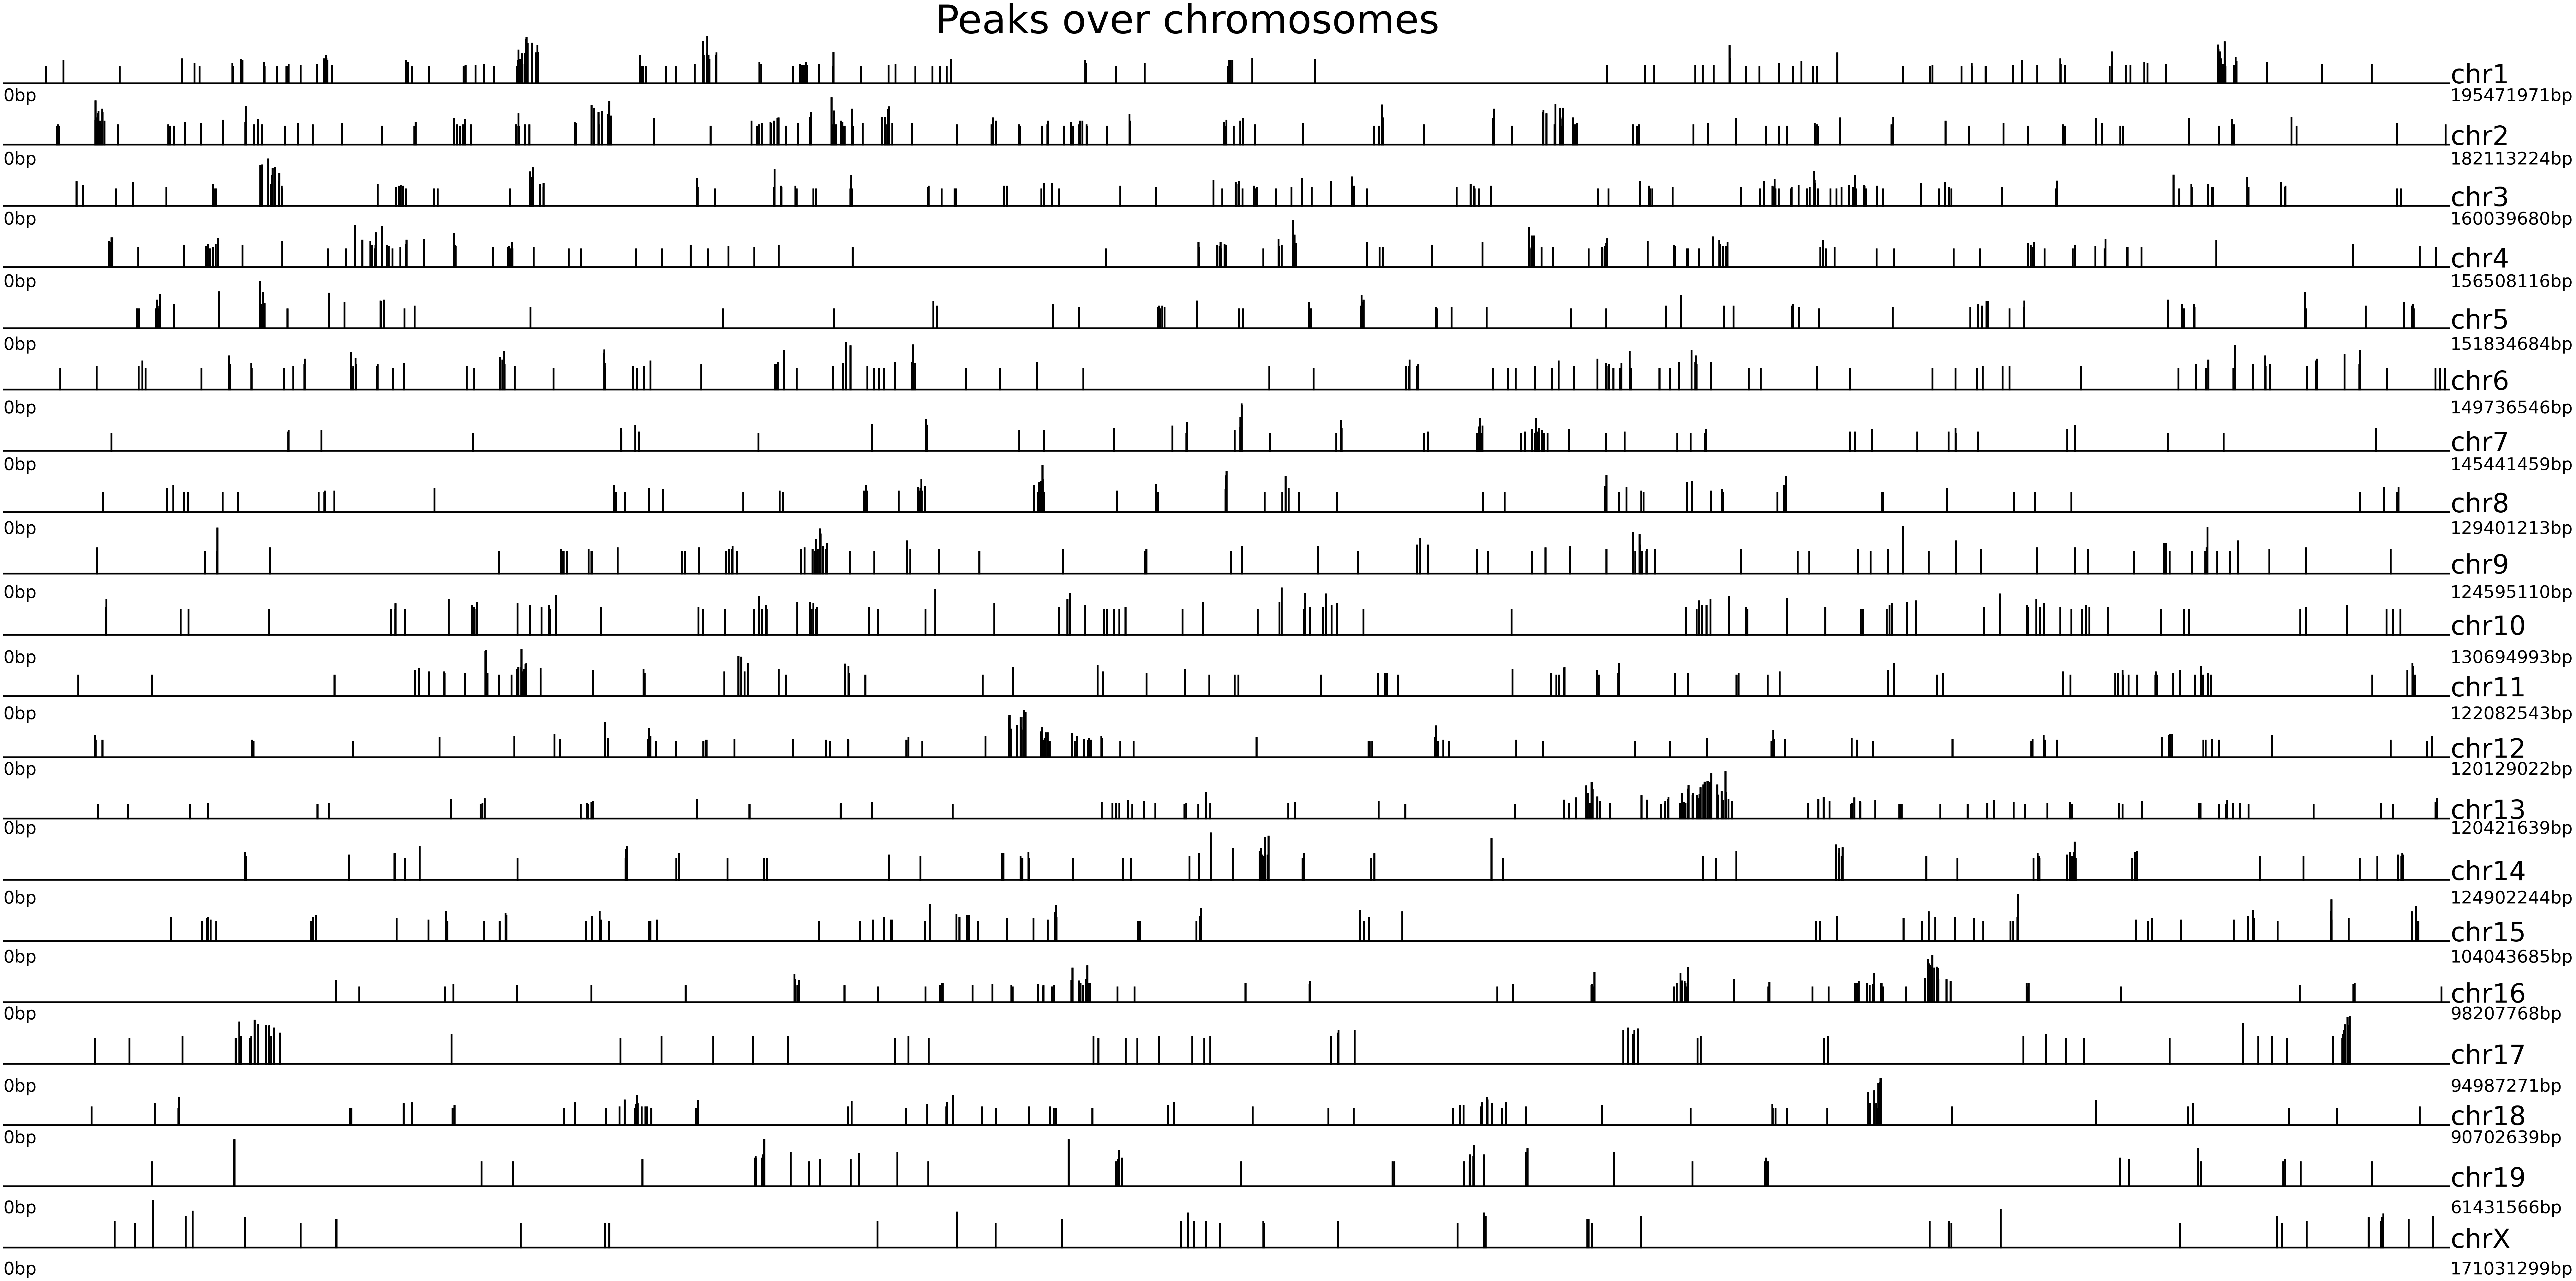

In [6]:
cc.pl.whole_peaks(peak_data, reference = "mm10")

In the next step, we annotate the peaks by their closest genes using [bedtools](https://bedtools.readthedocs.io/en/latest/) and [pybedtools](https://daler.github.io/pybedtools/).
Make sure they are all previously installed before using.

In [7]:
peak_annotation = cc.pp.annotation(peak_data, reference = "mm10")
peak_annotation = cc.pp.combine_annotation(peak_data,peak_annotation)
peak_annotation

In the bedtools method, we would use bedtools in the default path. Set bedtools path by 'bedtools_path' if needed.


,Chr,Start,End,Experiment Insertions,Reference Insertions,Expected Insertions,pvalue,Nearest Refseq1,Gene Name1,Nearest Refseq2,Gene Name2
0,chr1,3399868,3400272,5,4,1.031353,6.965061e-04,NM_001011874,Xkr4,NM_001195662,Rp1
1,chr1,4806673,4809049,12,20,1.120541,2.498336e-10,NM_008866,Lypla1,NR_033530,Mrpl15
2,chr1,9300144,9300901,5,5,1.037149,7.168254e-04,NM_001290390,Sntg1,NM_021511,Rrs1
3,chr1,14302176,14310895,14,92,1.523252,1.015569e-10,NM_010164,Eya1,NM_010827,Msc
4,chr1,15287495,15288141,8,4,1.029800,1.427167e-06,NM_001098528,Kcnb2,NM_177781,Trpa1
...,...,...,...,...,...,...,...,...,...,...,...
2166,chrX,166172262,166174518,6,10,1.137755,1.824630e-04,NM_001310724,Gemin8,NM_023122,Gpm6b
2167,chrX,166241178,166243587,8,18,1.257844,7.050309e-06,NM_023122,Gpm6b,NM_001310724,Gemin8
2168,chrX,166345453,166350005,11,35,1.507674,7.204418e-08,NM_023122,Gpm6b,NM_177429,Ofd1
2169,chrX,168117814,168120255,7,21,1.162110,2.957329e-05,NM_001290427,Frmpd4,NM_001290428,Frmpd4


Then, we read the barocede file.

In [8]:
barcodes = cc.datasets.mousecortex_data(data="barcodes")
barcodes

,index
0,AAACCTGAGAACTCGG-1
1,AAACCTGAGCAATCTC-1
2,AAACCTGAGCCGTCGT-1
3,AAACCTGAGTAGCGGT-1
4,AAACCTGAGTGGAGTC-1
...,...
35945,TTTGTCAAGTCCCACG-1
35946,TTTGTCACAGCGTCCA-1
35947,TTTGTCACATTTCACT-1
35948,TTTGTCAGTCGCATCG-1


Use qbed data, peak data and barcode data to make a cell by peak [Anndata](https://anndata.readthedocs.io/en/latest/) object.

In [9]:
adata_cc = cc.pp.make_Anndata(qbed_data, peak_annotation, barcodes)
adata_cc

100%|██████████| 20/20 [00:01<00:00, 18.66it/s]


AnnData object with n_obs × n_vars = 35950 × 2171
    var: 'Chr', 'Start', 'End', 'Experiment Insertions', 'Reference Insertions', 'Expected Insertions', 'pvalue', 'Nearest Refseq1', 'Gene Name1', 'Nearest Refseq2', 'Gene Name2'

Calling cards data is sequenced along with RNA-seq data. For the following steps, we are going to read scRNA-seq data and analyze them together. [Scanpy](https://scanpy.readthedocs.io/en/stable/) is recommended to load and analyze scRNA-seq data.

In [10]:
adata = cc.datasets.mousecortex_data(data="RNA")
adata

AnnData object with n_obs × n_vars = 30300 × 2638
    obs: 'batch', 'n_genes', 'total_counts', 'cluster'
    var: 'n_counts', 'n_cells', 'highly_variable'

In the scRNA-seq analysis, many cells are filtered because of low quility. We need to make the cells in qbed anndata to be the exactly same as RNA-seq anndata.

In [11]:
adata_cc = adata_cc[adata.obs.index]
adata_cc,adata_cc.X,adata_cc.obs.index==adata_cc.obs.index

(View of AnnData object with n_obs × n_vars = 30300 × 2171
     var: 'Chr', 'Start', 'End', 'Experiment Insertions', 'Reference Insertions', 'Expected Insertions', 'pvalue', 'Nearest Refseq1', 'Gene Name1', 'Nearest Refseq2', 'Gene Name2',
 <30300x2171 sparse matrix of type '<class 'numpy.float32'>'
 	with 19818 stored elements in Compressed Sparse Column format>,
 array([ True,  True,  True, ...,  True,  True,  True]))

Many results for RNA could be used in calling cards analysis. Here, we borrow clustering information from scRNA-seq data.

In [12]:
adata_cc.obs[['cluster']] = adata.obs[['cluster']]
adata_cc.obs

/tmp/ipykernel_4190809/404784706.py:1: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata_cc.obs[['cluster']] = adata.obs[['cluster']]


,cluster
index,
AAACCTGAGAACTCGG-1,Neuron_Excit_L5_Mixed
AAACCTGAGCCGTCGT-1,Astrocyte
AAACCTGAGTAGCGGT-1,Astrocyte
AAACCTGAGTGGAGTC-1,Neuron_Inhibitory
AAACCTGCAGCATGAG-1,Astrocyte
...,...
TTTGTCAAGTCCCACG-1,Neuron_Granule_DG
TTTGTCACAGCGTCCA-1,Neuron_Cajal-Retzius
TTTGTCACATTTCACT-1,Neuron_Granule_DG


Although one peak should have many insertions, but there is a chance that all the cells from the peak was filtered by the RNA preprocesssing. In this case, we advise to filter peaks by the minimum number of cells. 

In [13]:
cc.pp.filter_peaks(adata_cc, min_counts=1)

Differential peak analysis shows significant bindings for each cluster. In this example, we use *binomial test* to find out.

In [14]:
cc.tl.rank_peak_groups(adata_cc,"cluster",method = 'binomtest',key_added = 'binomtest')

100%|██████████| 18/18 [03:59<00:00, 13.30s/it]


Plot the results for differential peak analysis.

Currently, the peaks are ranked by pvalues. It could also be ranked by logfoldchanges by the following codes:

```python
cc.tl.rank_peak_groups(adata_cc,"cluster",method = 'binomtest',rankby = 'logfoldchanges')
cc.pl.rank_peak_groups(adata_cc, key = 'binomtest',rankby = 'logfoldchanges')

```

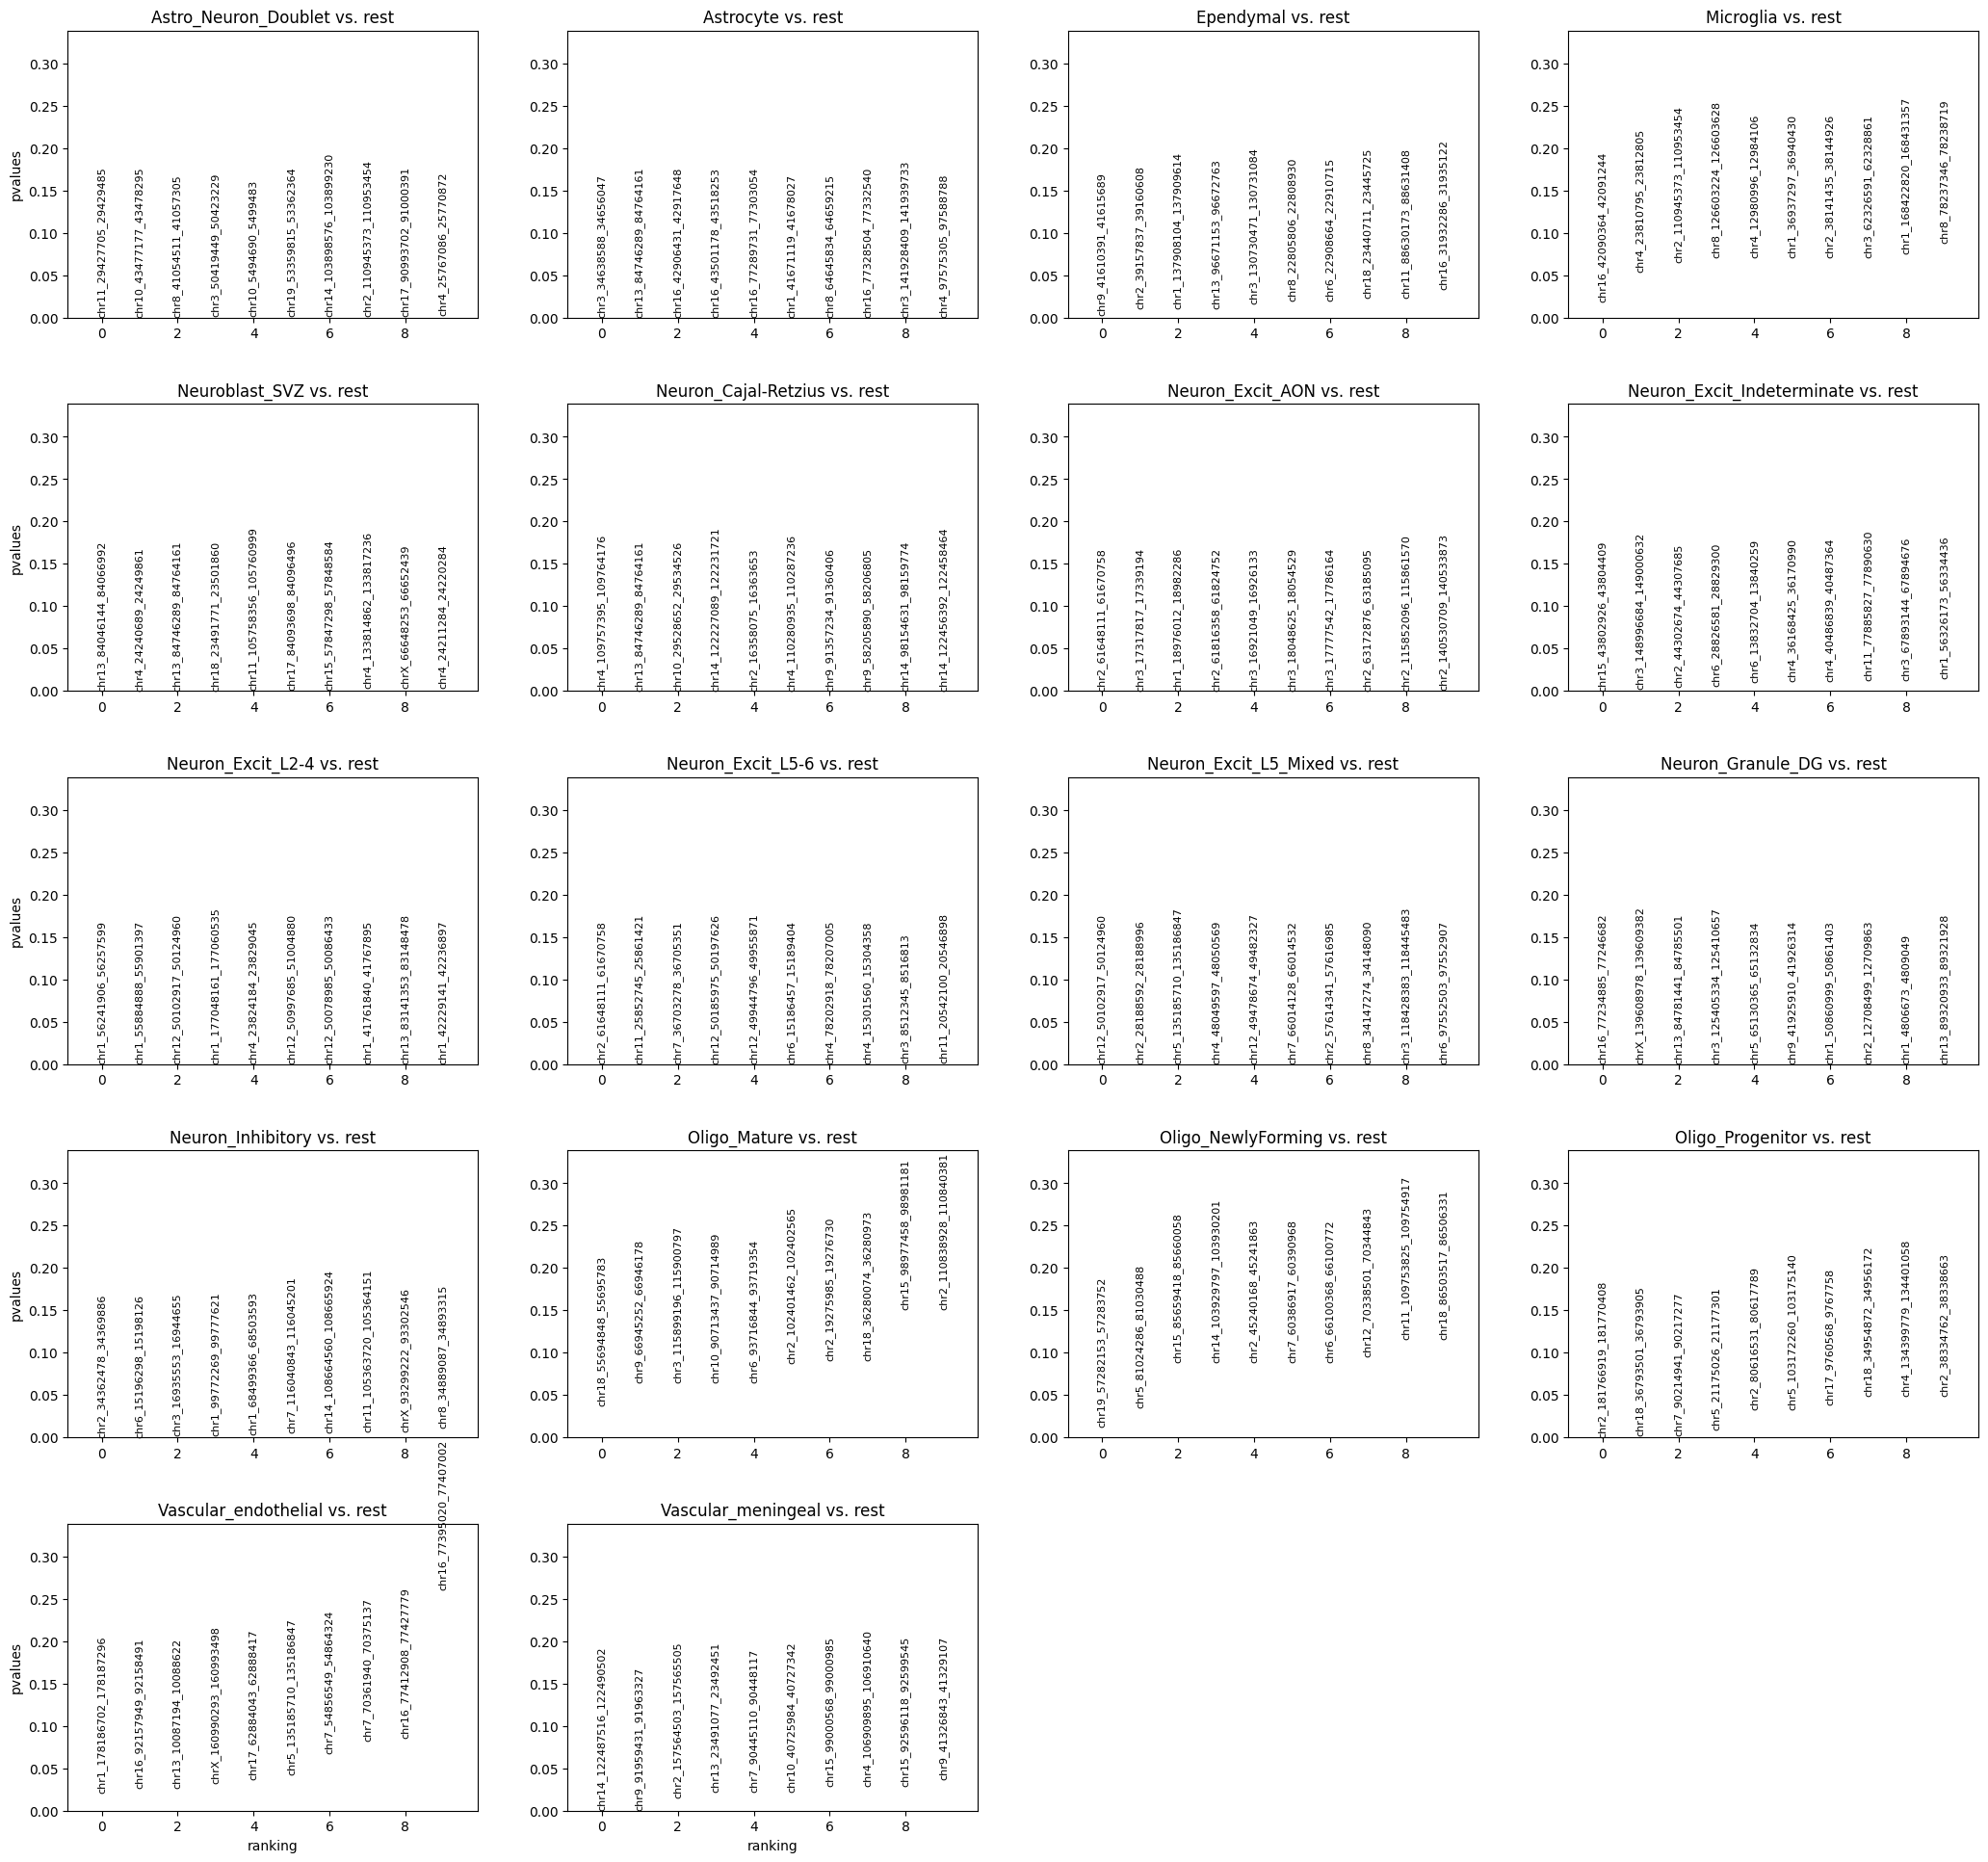

In [15]:
cc.pl.rank_peak_groups(adata_cc, key = 'binomtest', save = True)

Then, we take a look at the genome for the highly differentiated peaks. The colored ones are the insertions for specific cluster and the grey ones are the total insertions for the whole dataset. We could see that most of insertions are from Astrocyte in the following peaks.

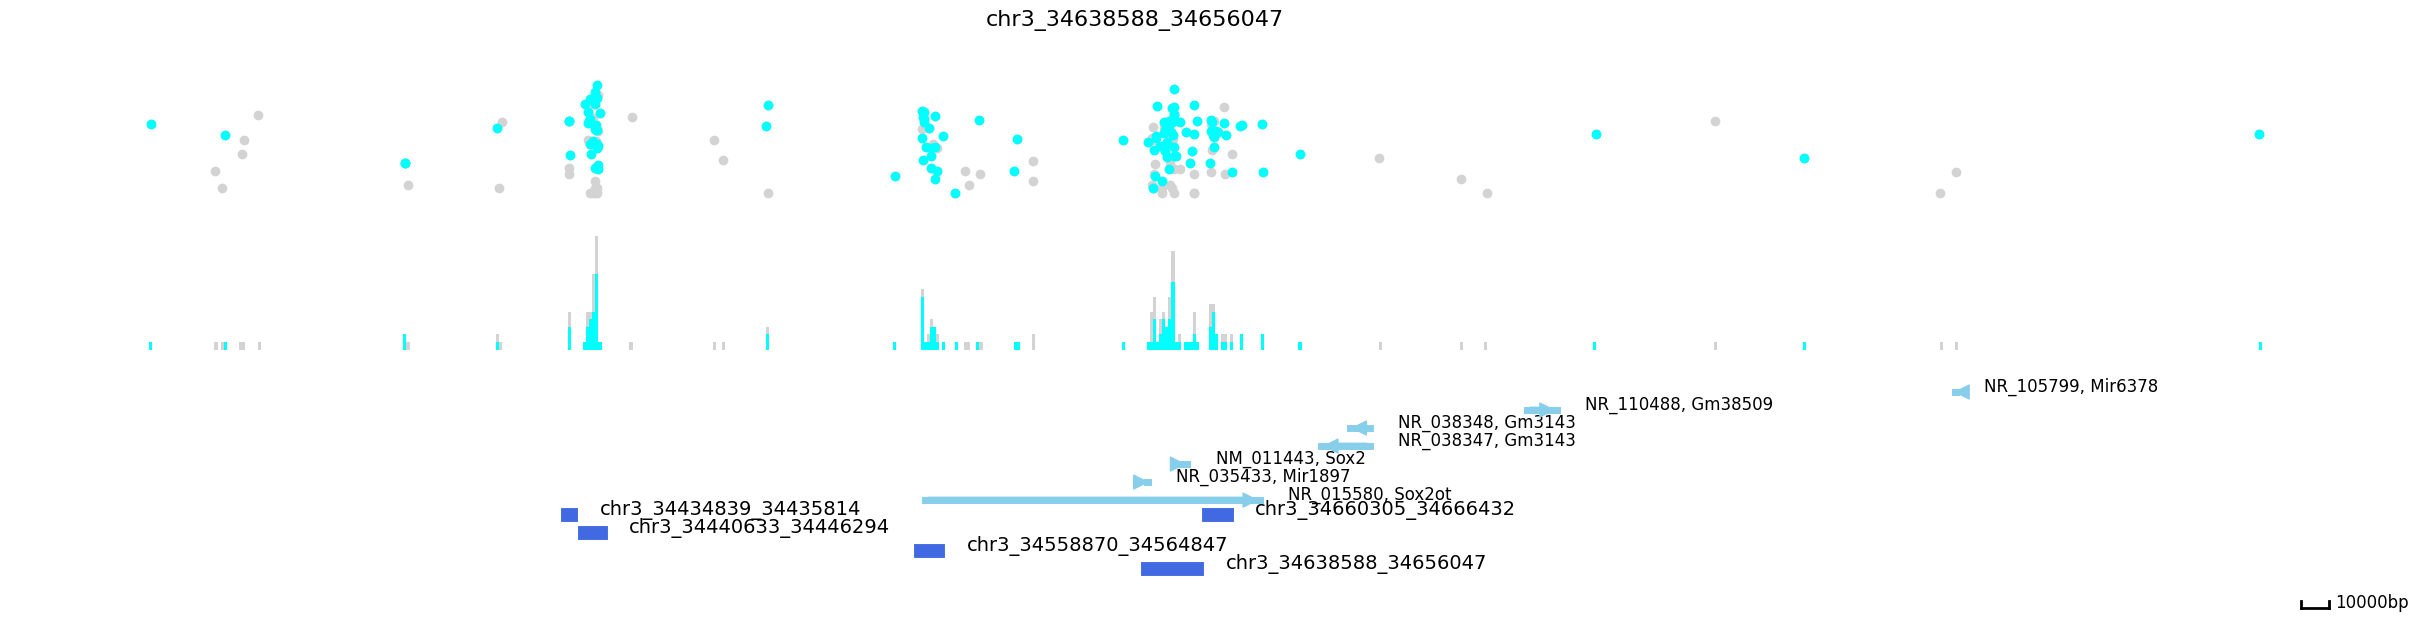

In [16]:
cc.pl.draw_area("chr3",34638588,34656047,400000,peak_data,qbed_data,"mm10",adata = adata_cc,
                name = 'Astrocyte',key ='cluster',figsize = (30,7),peak_line = 4,color = "blue", title = "chr3_34638588_34656047")

If the peak and the related refernce genes is also differential, we then see whether there is a relationship between the binding and gene experssion.

Let's do the differential expression analysis for scRNA-seq data.

In [17]:
sc.tl.rank_genes_groups(adata,'cluster')

Find out the co-differential peak-gene pairs. It would look into all the differential peaks in each cluster and then see if the annotated genes are also significant expressed in ths cluster. We could set the pvalue and score/log foldchange cutoff easily.


In [18]:
result = cc.tl.pair_peak_gene_sc(adata_cc,adata,peak_annotation, pvalue_cutoff_cc = 0.001, pvalue_cutoff_rna = 0.001, lfc_cutoff = 3, score_cutoff = 3)
result

,Cluster,Peak,Logfoldchanges,Pvalue_peak,Gene,Score_gene,Pvalue_gene
0,Astrocyte,chr16_43501178_43518253,3.077262,1.462410e-16,Zbtb20,79.234276,0.000000e+00
1,Astrocyte,chr8_64645834_64659215,4.623955,3.114365e-14,Msmo1,61.964111,0.000000e+00
2,Astrocyte,chr3_141928409_141939733,4.876938,3.786296e-14,Bmpr1b,24.131538,2.475603e-121
3,Astrocyte,chr4_97575305_97588788,3.099679,5.907086e-14,E130114P18Rik,16.893749,3.380841e-62
4,Astrocyte,chr4_97575305_97588788,3.099679,5.907086e-14,Nfia,45.417362,0.000000e+00
...,...,...,...,...,...,...,...
122,Neuron_Granule_DG,chr13_89320933_89321928,4.399915,7.818271e-04,Hapln1,-14.765965,9.061876e-44
123,Neuron_Inhibitory,chr2_34362478_34369886,3.988165,1.977978e-04,Pbx3,15.902434,5.024489e-54
124,Neuron_Inhibitory,chr6_15196298_15198126,10.414956,3.822503e-04,Foxp2,20.337471,1.781142e-84
125,Vascular_meningeal,chr14_122487516_122490502,7.469697,1.026983e-07,Zic2,7.556187,1.062384e-12


Draw the above results to find out potential relationship between TF bindings and gene expression.

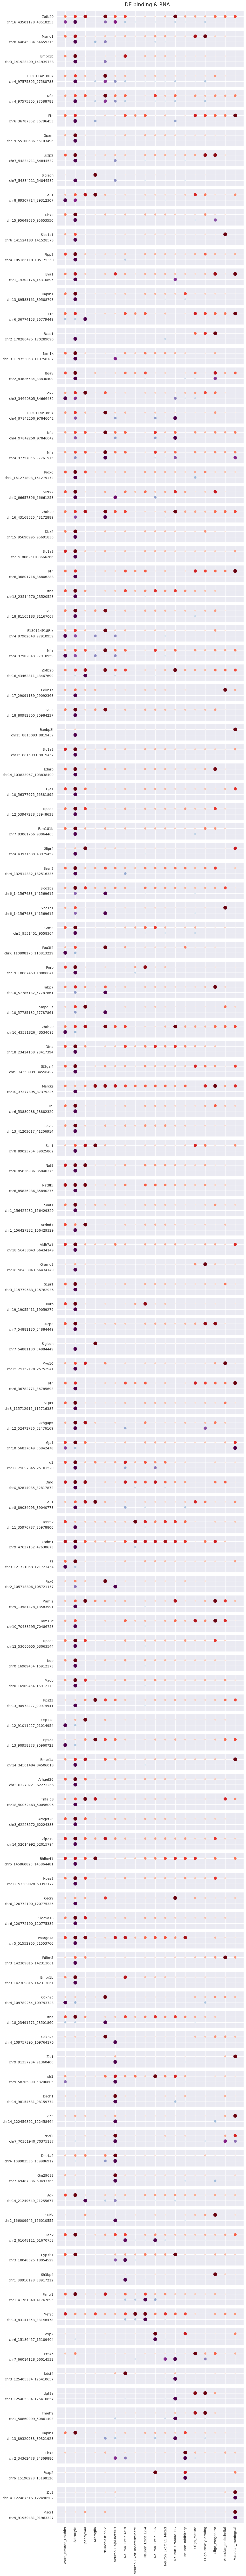

In [19]:
cc.pl.dotplot_sc(adata_cc,adata,result)

After seeing the dotplot above, grab some peaks to the RNA Anndata object and see the distribution in UMAP plot.

In [ ]:
sc.pp.pca(adata)
sc.pp.neighbors(adata)
sc.tl.umap(adata)

The first plot is the average insertions of peak in each cluster, the second plot is the gene expression Gou3f2 (one of its nearest genes for the peak) and the third plot is the cluster information.

In [ ]:
p = "chr4_22969921_22973019"
adata = cc.pp.adata_insertions(adata_cc,adata,p,method="logAvginsertions" ,peak = p)
sc.pl.umap(adata, color=[p,'Pou3f2','cluster'])

In [ ]:
p = 'chr1_42253068_42265192'
adata = cc.pp.adata_insertions(adata_cc,adata,p,method="logAvginsertions" ,peak = p)
sc.pl.umap(adata, color=[p,'Pou3f3','cluster'])

We could see the potential relationship between bindings and gene expression.

Now, we could make these hypothses in mouse. However, we could try to map the binding sites and gene to human. We use and adpat [liftover](https://genome.ucsc.edu/cgi-bin/hgLiftOver) to get the resuls.

In [ ]:
result = cc.tl.result_mapping(result)
result

We search [GWAS Catalog database](https://www.ebi.ac.uk/gwas/docs/file-downloads) and find out related SNPs in the binding areas.

In [ ]:
result = cc.tl.GWAS(result)
adata_cc.uns["pair"] = result
adata_cc.uns["pair"]

Save the file if needed.

In [ ]:
adata_cc.write("Mouse-Cortex.h5ad")